In [1]:
import warnings
warnings.filterwarnings("ignore")

print("완료!")

완료!


In [2]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [3]:
import tensorflow_datasets as tfds

tfds.__version__

'4.4.0'

In [4]:
!mkdir -p ~/aiffel/cats_vs_dogs/PetImages
!ln -s ~/data/* ~/aiffel/cats_vs_dogs/

ln: failed to create symbolic link '/aiffel/aiffel/cats_vs_dogs/cat_face.jpg': File exists
ln: failed to create symbolic link '/aiffel/aiffel/cats_vs_dogs/cats_vs_dogs': File exists
ln: failed to create symbolic link '/aiffel/aiffel/cats_vs_dogs/my_cat.jpg': File exists
ln: failed to create symbolic link '/aiffel/aiffel/cats_vs_dogs/my_dog.jpg': File exists


In [5]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/cats_vs_dogs/',
    download=False,
    with_info=True,
    as_supervised=True,
)

In [6]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("슝~")

슝~


raw_train 안에 있는 데이터를 확인해 보기 위해 tf.data.Dataset에서 제공하는 take라는 함수를 사용해 보겠습니다. 이 함수는 인수로 받은 만큼의 개수만큼의 데이터를 추출하여 새로운 데이터셋 인스턴스를 생성하여 리턴하는 함수입니다.

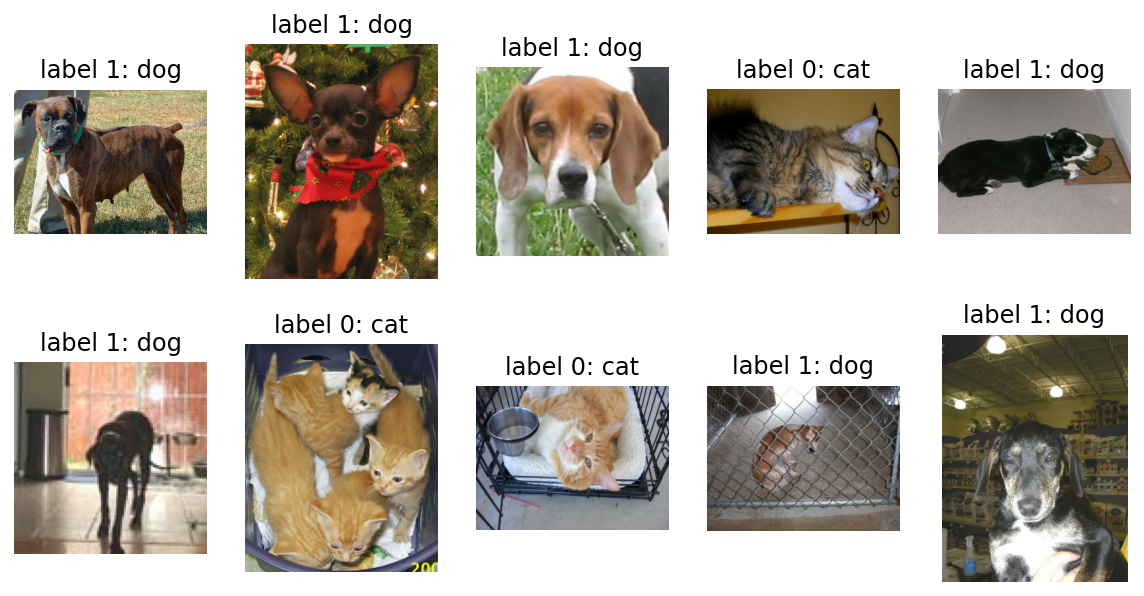

In [8]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

강아지는 label 1로, 고양이는 label 0으로 설정되어 있군요. 앞서 설명했듯 이미지의 사이즈는 전부 제각각이네요. 모델을 학습시킬 때에는 이미지 사이즈를 통일시켜 주는 작업을 해야할 것 같습니다.

format_example() 함수를 이용해 이미지를 같은 포맷으로 통일 시켜 봅시다.

아래 코드는 이미지의 사이즈를 160x160 픽셀로 통일시킬 뿐만 아니라, 각 픽셀값의 scale을 수정해주는 역할도 합니다.

‍🌈 간단 상식 - 타입캐스팅(Type Casting)
형변환이라고도 불리는 타입개스팅은 다른 데이터 타입으로 형(타입)을 바꿔주는 것을 의미합니다.    
정수형을 실수형으로 바꾸기 위해 float()를 사용하는 것이 타입캐스팅의 한 예입니다.

In [9]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

print("슝~")

슝~


0~255 사이의 값들을 그 중간값인 127.5로 나누고 1을 뺐으므로, -1에서1 사이의 실수값이 된다.

In [10]:
a = [1.2, 2.5, 3.7, 4.6] a = list(map(int, a))# 리스트의 요소를 정수로 변환 하여 리스트로 생성
a

[1, 2, 3, 4]

In [11]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


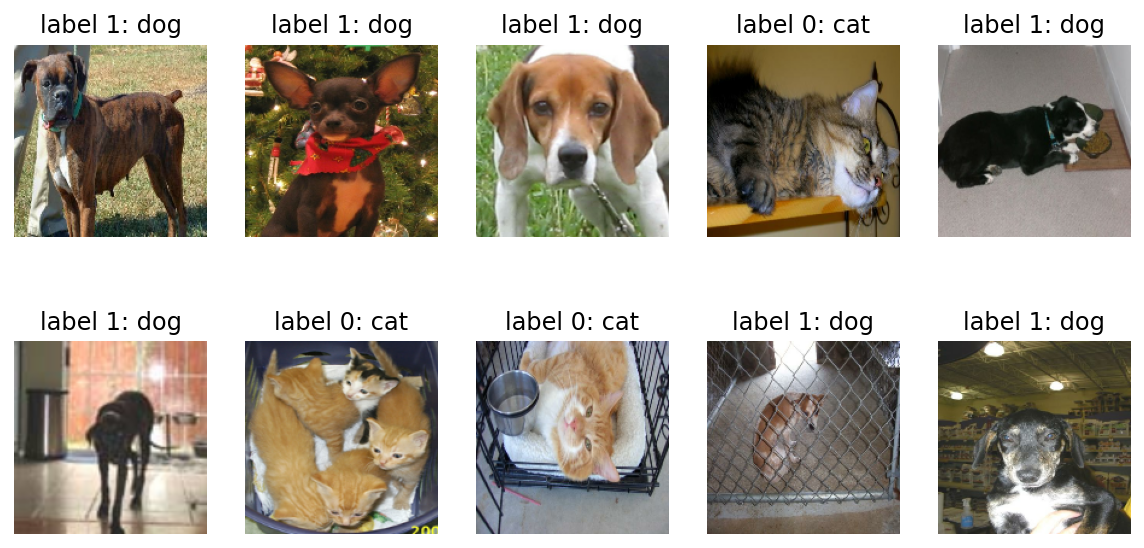

In [12]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

print("슝~")

슝~


In [14]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])

print("슝~")

슝~


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

In [16]:
import numpy as np

image = np.array([[1, 2], [3, 4]])
print(image.shape)
image

(2, 2)


array([[1, 2],
       [3, 4]])

In [17]:
image.flatten()

array([1, 2, 3, 4])

In [18]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

print("슝~")

슝~


In [19]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
print("슝~")

슝~


In [21]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)
print("슝~")

슝~


In [22]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [23]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

 9/20 [============>.................] - ETA: 0s - loss: 0.6993 - accuracy: 0.4514

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 21s 52ms/step - loss: 0.6938 - accuracy: 0.4875
initial loss: 0.69
initial accuracy: 0.49


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


In [24]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
167/582 [=======>......................] - ETA: 34s - loss: 0.6871 - accuracy: 0.5947

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 32s - loss: 0.6744 - accuracy: 0.6088

209/582 [=========>....................] - ETA: 31s - loss: 0.6715 - accuracy: 0.6120

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 24s - loss: 0.6524 - accuracy: 0.6267

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.6144 - accuracy: 0.6590

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.6130 - accuracy: 0.6605

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.6114 - accuracy: 0.6619

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.6064 - accuracy: 0.6656

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 2s - loss: 0.6064 - accuracy: 0.6658

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6020 - accuracy: 0.6688

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 56s 89ms/step - loss: 0.6020 - accuracy: 0.6688 - val_loss: 0.5545 - val_accuracy: 0.7206
Epoch 2/10
167/582 [=======>......................] - ETA: 33s - loss: 0.5214 - accuracy: 0.7436

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 31s - loss: 0.5186 - accuracy: 0.7425

209/582 [=========>....................] - ETA: 30s - loss: 0.5183 - accuracy: 0.7440

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 24s - loss: 0.5124 - accuracy: 0.7462

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.4959 - accuracy: 0.7555

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.4949 - accuracy: 0.7564

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.4943 - accuracy: 0.7574

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.4913 - accuracy: 0.7594

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.4908 - accuracy: 0.7598

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.4902 - accuracy: 0.7601

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 52s 86ms/step - loss: 0.4900 - accuracy: 0.7601 - val_loss: 0.4990 - val_accuracy: 0.7623
Epoch 3/10
167/582 [=======>......................] - ETA: 36s - loss: 0.4476 - accuracy: 0.7955

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 33s - loss: 0.4500 - accuracy: 0.7919

209/582 [=========>....................] - ETA: 33s - loss: 0.4483 - accuracy: 0.7925

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 26s - loss: 0.4423 - accuracy: 0.7947

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.4274 - accuracy: 0.8015

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.4259 - accuracy: 0.8026

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.4253 - accuracy: 0.8032

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.4234 - accuracy: 0.8043

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.4237 - accuracy: 0.8041

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4237 - accuracy: 0.8039

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 55s 90ms/step - loss: 0.4237 - accuracy: 0.8039 - val_loss: 0.5521 - val_accuracy: 0.7382
Epoch 4/10
170/582 [=======>......................] - ETA: 17s - loss: 0.3928 - accuracy: 0.8256

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 [=========>....................] - ETA: 16s - loss: 0.3887 - accuracy: 0.8277

212/582 [=========>....................] - ETA: 15s - loss: 0.3881 - accuracy: 0.8284

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 12s - loss: 0.3841 - accuracy: 0.8299

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 [========================>.....] - ETA: 3s - loss: 0.3727 - accuracy: 0.8362

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 [=========================>....] - ETA: 3s - loss: 0.3717 - accuracy: 0.8363

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 2s - loss: 0.3708 - accuracy: 0.8363

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 1s - loss: 0.3695 - accuracy: 0.8368

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


549/582 [===========================>..] - ETA: 1s - loss: 0.3691 - accuracy: 0.8367

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.3684 - accuracy: 0.8369

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 27s 45ms/step - loss: 0.3684 - accuracy: 0.8370 - val_loss: 0.5186 - val_accuracy: 0.7691
Epoch 5/10
168/582 [=======>......................] - ETA: 34s - loss: 0.3415 - accuracy: 0.8538

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/582 [=========>....................] - ETA: 31s - loss: 0.3388 - accuracy: 0.8548

210/582 [=========>....................] - ETA: 30s - loss: 0.3381 - accuracy: 0.8543

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.3310 - accuracy: 0.8580

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 7s - loss: 0.3198 - accuracy: 0.8626

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.3196 - accuracy: 0.8625

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.3192 - accuracy: 0.8625

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.3170 - accuracy: 0.8635

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.3170 - accuracy: 0.8636

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.8634

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 51s 85ms/step - loss: 0.3165 - accuracy: 0.8634 - val_loss: 0.4802 - val_accuracy: 0.7825
Epoch 6/10
167/582 [=======>......................] - ETA: 35s - loss: 0.2825 - accuracy: 0.8810

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 32s - loss: 0.2809 - accuracy: 0.8825

209/582 [=========>....................] - ETA: 31s - loss: 0.2819 - accuracy: 0.8817

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.2745 - accuracy: 0.8864

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.2651 - accuracy: 0.8892

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.2631 - accuracy: 0.8901

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.2628 - accuracy: 0.8899

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.2612 - accuracy: 0.8906

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 2s - loss: 0.2618 - accuracy: 0.8902

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.2609 - accuracy: 0.8905 ETA: 2s - los

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 53s 87ms/step - loss: 0.2608 - accuracy: 0.8907 - val_loss: 0.5660 - val_accuracy: 0.7721
Epoch 7/10
169/582 [=======>......................] - ETA: 17s - loss: 0.2303 - accuracy: 0.9077

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/582 [=========>....................] - ETA: 16s - loss: 0.2303 - accuracy: 0.9090

213/582 [=========>....................] - ETA: 15s - loss: 0.2282 - accuracy: 0.9098

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 12s - loss: 0.2196 - accuracy: 0.9135

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 [========================>.....] - ETA: 3s - loss: 0.2134 - accuracy: 0.9172

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 [=========================>....] - ETA: 3s - loss: 0.2128 - accuracy: 0.9174

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


515/582 [=========================>....] - ETA: 2s - loss: 0.2122 - accuracy: 0.9175

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 1s - loss: 0.2109 - accuracy: 0.9180

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


548/582 [===========================>..] - ETA: 1s - loss: 0.2103 - accuracy: 0.9185

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.2099 - accuracy: 0.9180

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 28s 45ms/step - loss: 0.2099 - accuracy: 0.9179 - val_loss: 0.6564 - val_accuracy: 0.7545
Epoch 8/10
168/582 [=======>......................] - ETA: 29s - loss: 0.1839 - accuracy: 0.9356

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 27s - loss: 0.1828 - accuracy: 0.9352

211/582 [=========>....................] - ETA: 27s - loss: 0.1821 - accuracy: 0.9351

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 22s - loss: 0.1774 - accuracy: 0.9362

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.1684 - accuracy: 0.9388

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 6s - loss: 0.1667 - accuracy: 0.9397

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.1659 - accuracy: 0.9399

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.1648 - accuracy: 0.9403

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.1645 - accuracy: 0.9404

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.9408

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 50s 84ms/step - loss: 0.1632 - accuracy: 0.9408 - val_loss: 0.5638 - val_accuracy: 0.7721
Epoch 9/10
168/582 [=======>......................] - ETA: 35s - loss: 0.1390 - accuracy: 0.9509

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 32s - loss: 0.1357 - accuracy: 0.9528

210/582 [=========>....................] - ETA: 31s - loss: 0.1356 - accuracy: 0.9528

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.1305 - accuracy: 0.9543

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 7s - loss: 0.1266 - accuracy: 0.9558

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.1257 - accuracy: 0.9561

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.1258 - accuracy: 0.9559

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.1241 - accuracy: 0.9566

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.1236 - accuracy: 0.9568

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.1227 - accuracy: 0.9574

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 52s 86ms/step - loss: 0.1227 - accuracy: 0.9574 - val_loss: 0.6468 - val_accuracy: 0.7820
Epoch 10/10
167/582 [=======>......................] - ETA: 35s - loss: 0.1008 - accuracy: 0.9695

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 32s - loss: 0.0998 - accuracy: 0.9698

211/582 [=========>....................] - ETA: 31s - loss: 0.0993 - accuracy: 0.9704

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 25s - loss: 0.0953 - accuracy: 0.9713

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.0906 - accuracy: 0.9722

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 6s - loss: 0.0898 - accuracy: 0.9727

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.0896 - accuracy: 0.9727

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.0878 - accuracy: 0.9736

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.0879 - accuracy: 0.9735

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.0876 - accuracy: 0.9737

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 54s 89ms/step - loss: 0.0876 - accuracy: 0.9737 - val_loss: 0.7758 - val_accuracy: 0.7635


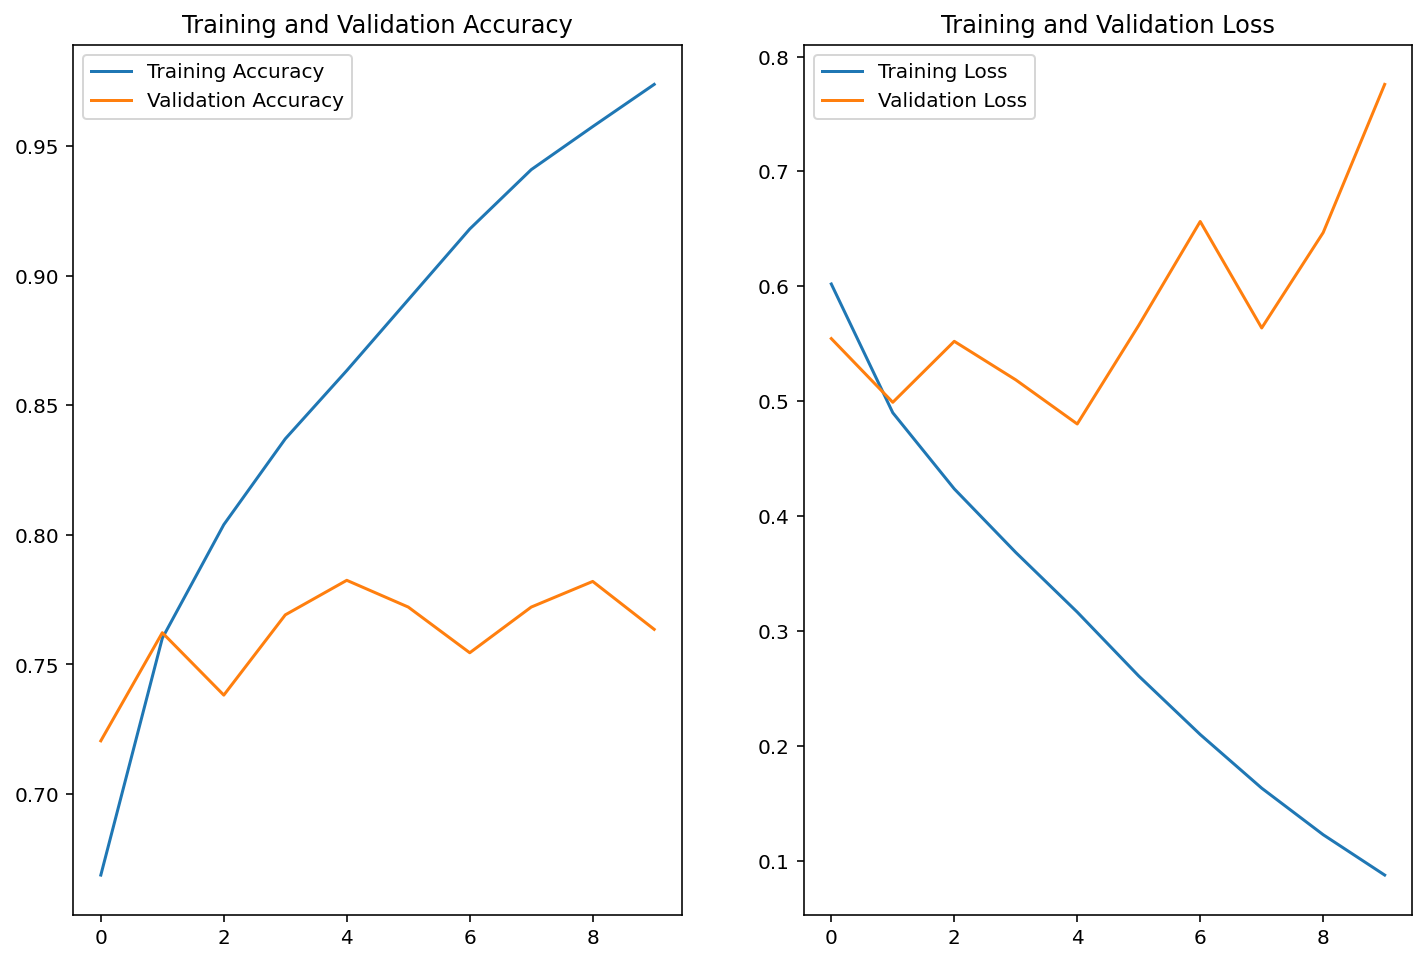

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [26]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions

array([[9.9998534e-01, 1.4717410e-05],
       [9.9199218e-01, 8.0078682e-03],
       [7.2091848e-01, 2.7908152e-01],
       [9.9999952e-01, 4.8432452e-07],
       [9.9825031e-01, 1.7497088e-03],
       [9.4442707e-01, 5.5572961e-02],
       [1.8287227e-01, 8.1712776e-01],
       [8.7732023e-01, 1.2267973e-01],
       [4.0264133e-01, 5.9735864e-01],
       [3.4816912e-01, 6.5183091e-01],
       [1.3628654e-01, 8.6371344e-01],
       [9.9991012e-01, 8.9827910e-05],
       [9.9960178e-01, 3.9823321e-04],
       [2.0220943e-04, 9.9979776e-01],
       [9.9683940e-01, 3.1605391e-03],
       [9.9992347e-01, 7.6473858e-05],
       [7.3123229e-01, 2.6876771e-01],
       [9.2737861e-03, 9.9072623e-01],
       [9.6895558e-01, 3.1044392e-02],
       [9.9718386e-01, 2.8161216e-03],
       [9.8653400e-01, 1.3465970e-02],
       [9.9921691e-01, 7.8308134e-04],
       [9.9995327e-01, 4.6756322e-05],
       [9.9913907e-01, 8.6093595e-04],
       [9.9445629e-01, 5.5436515e-03],
       [8.0641550e-01, 1.

In [27]:
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

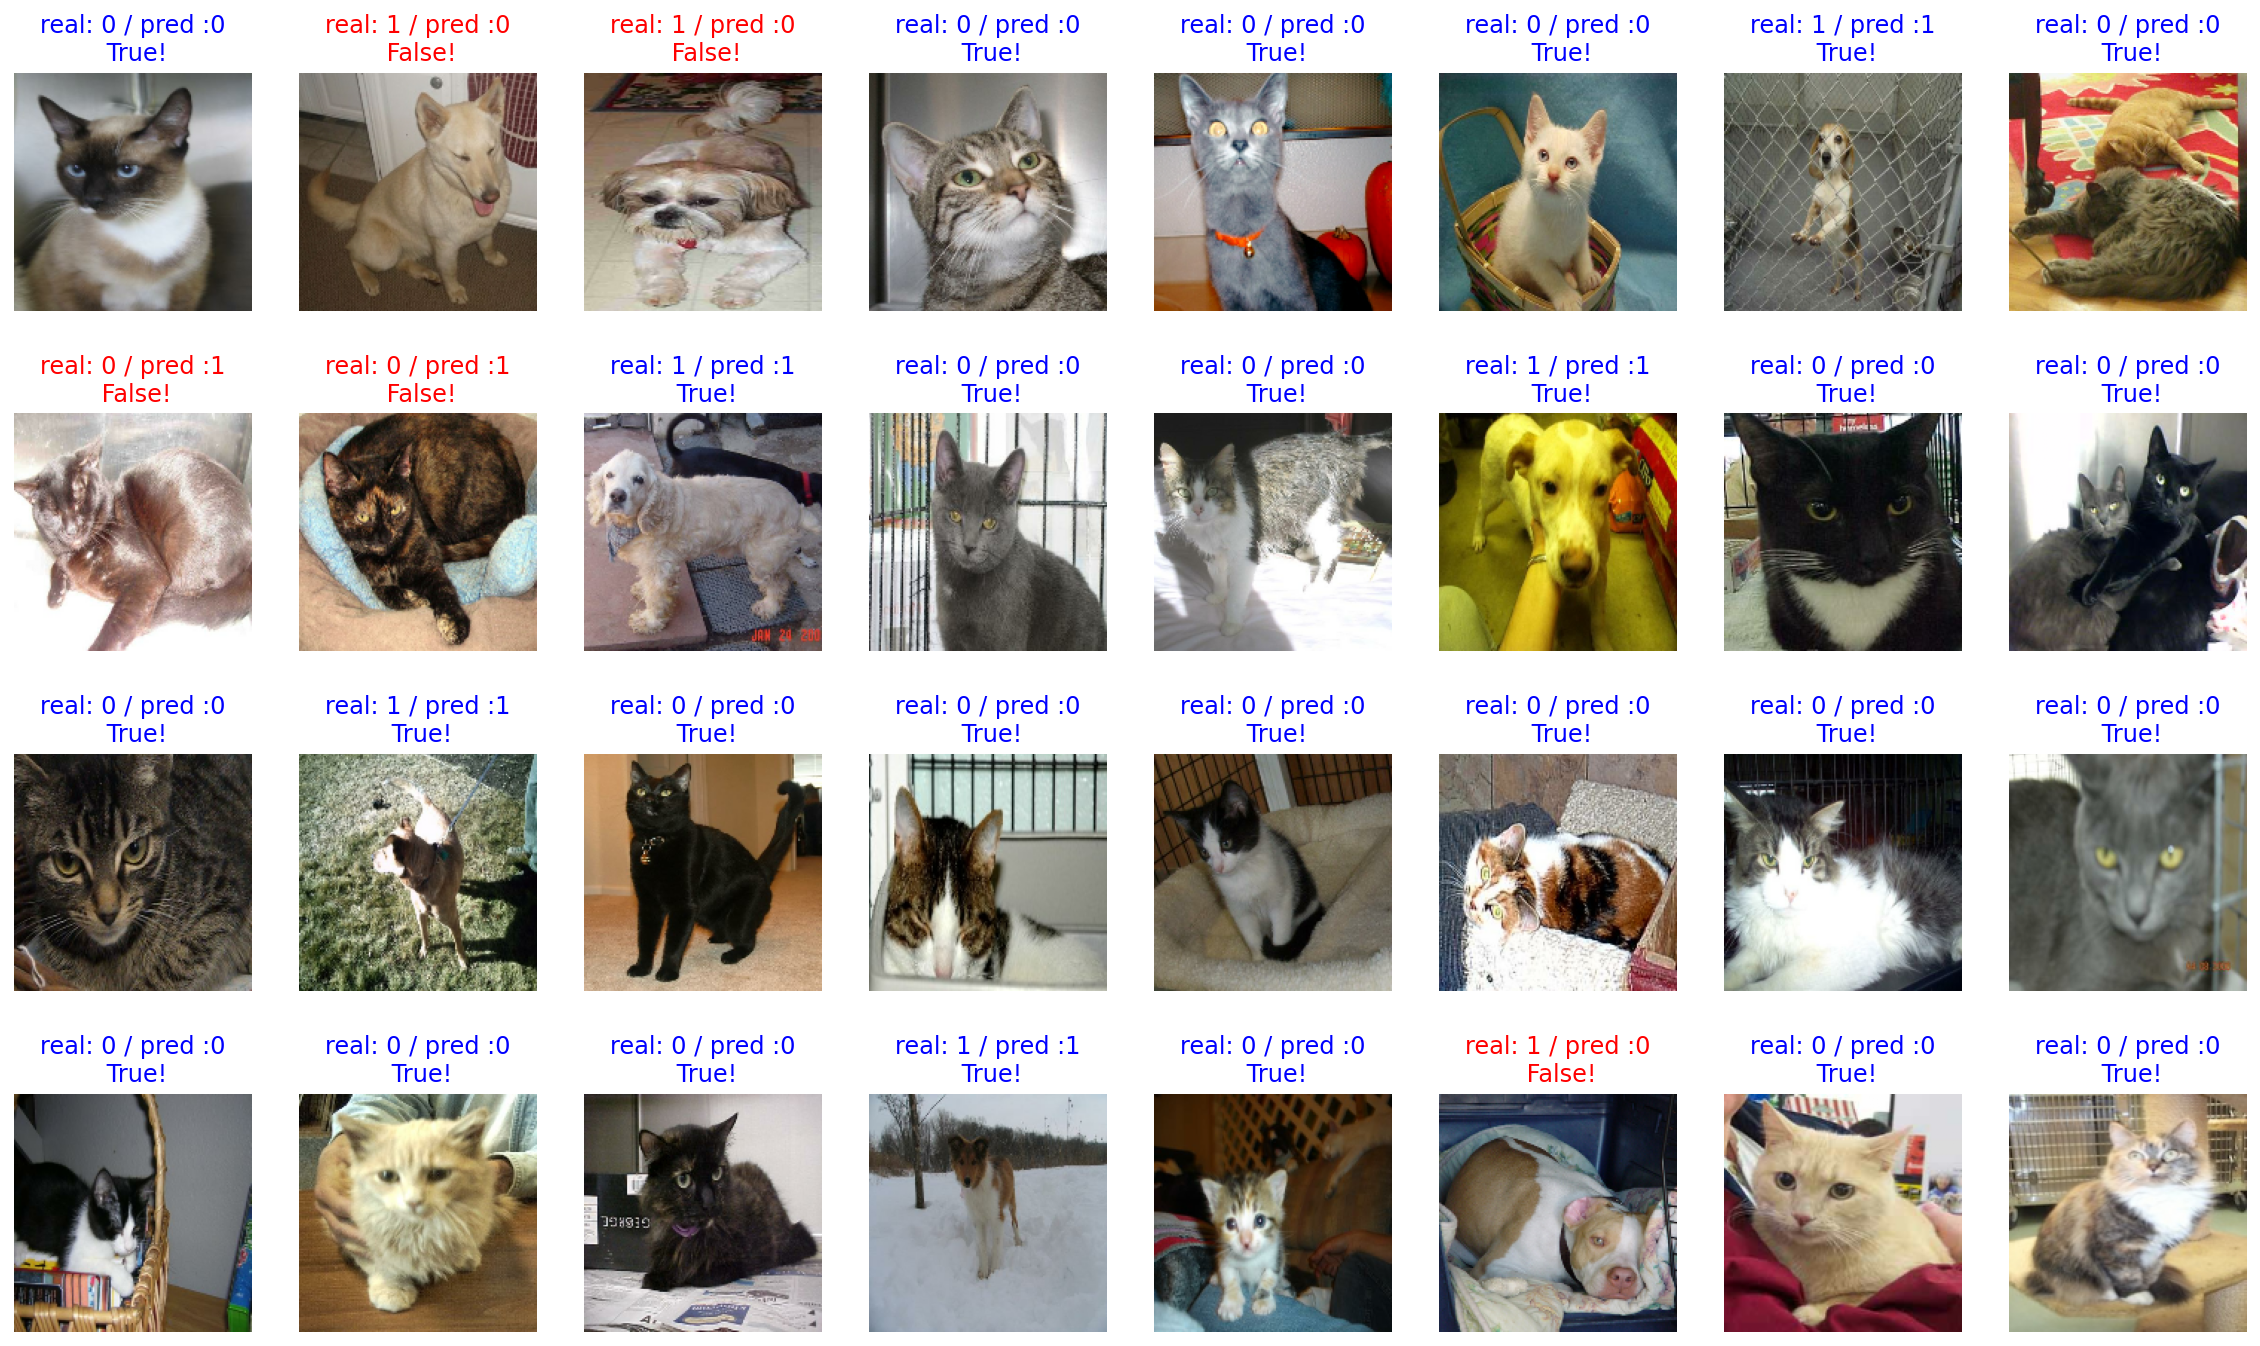

In [28]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [31]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

84.375


In [32]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [33]:
image_batch.shape

TensorShape([32, 160, 160, 3])

In [34]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [35]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [36]:
import numpy as np

image = np.array([[1, 2],
                  [3, 4]])

flattened_image = image.flatten()

print("Original image:\n", image)
print("Original image shape:", image.shape)
print()
print("Flattened image:\n", flattened_image)
print("Flattened image shape:", flattened_image.shape)

Original image:
 [[1 2]
 [3 4]]
Original image shape: (2, 2)

Flattened image:
 [1 2 3 4]
Flattened image shape: (4,)


In [37]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
print("슝~")

슝~


In [38]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [44]:
# dense layer에는 unit과 activation 2개의 매개변수만 사용해주세요.
# unit의 값은 위에서 global_average_layer를 통과했을 때의 값을 생각해보세요.
# 활성화 함수는 ReLU를 사용합니다.
dense_layer = tf.keras.layers.Dense(units=2, activation='ReLU')
# unit은 우리가 분류하고 싶은 class를 생각해보세요.
# 활성화 함수는 Softmax를 사용합니다.
prediction_layer = tf.keras.layers.Dense(units=1, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 1)


In [45]:
base_model.trainable = False
print("슝~")

슝~


In [46]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])
print("슝~")

슝~


In [47]:
base_learning_rate = 0.0001
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

 6/20 [========>.....................] - ETA: 0s - loss: 0.7097 - accuracy: 0.5417

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


18/20 [==========================>...] - ETA: 0s - loss: 0.7159 - accuracy: 0.5295

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


20/20 [==============================] - 6s 66ms/step - loss: 0.7169 - accuracy: 0.5297
initial loss: 0.72
initial accuracy: 0.53


In [49]:
EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

NameError: name 'x_train' is not defined